In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from itertools import combinations
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset
data = pd.read_csv("C:/Users/18215/Desktop/Coding/India_Air_Quality/data.csv", encoding="ISO-8859-1")

C:\Users\18215\AppData\Local\Temp\ipykernel_23584\2427617641.py:14: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:/Users/18215/Desktop/Coding/India_Air_Quality/data.csv", encoding="ISO-8859-1")


In [198]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax, legend=False)
    p_value = sm.tsa.stattools.adfuller(y.dropna())[1]
    ts_ax.set_title(f'Time Series Analysis Plots\nDickey-Fuller p-value = {p_value:.5f}')
    smt.graphics.plot_acf(y.dropna(), lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y.dropna(), lags=lags, ax=pacf_ax)
    plt.tight_layout()
    plt.show()

In [199]:
data = data.dropna(subset=["date"])
data["date"] = pd.to_datetime(data["date"])
data["year"] = data["date"].dt.year
data["year"] = data["year"].astype(int)
data["month"] = data["date"].dt.month
data["month"] = data["month"].astype(int)

SO2 Prediction

C:\Users\18215\AppData\Local\Temp\ipykernel_23584\3418096679.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_so2 = data_so2.resample("M").mean().interpolate()


<Axes: xlabel='date'>

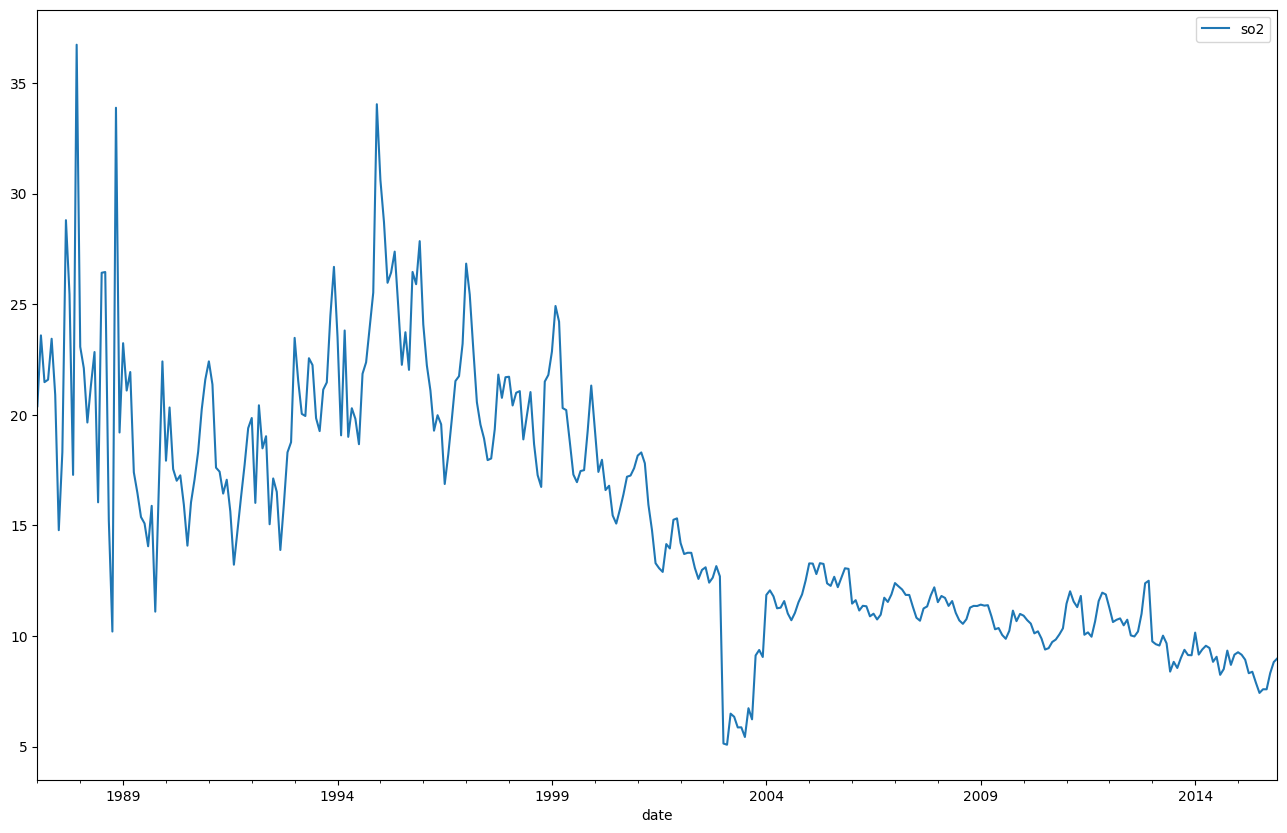

In [200]:
data_so2 = data[["date", "so2"]].set_index("date").dropna()
data_so2 = data_so2.resample("M").mean().interpolate()
data_so2.plot(figsize = (16, 10))

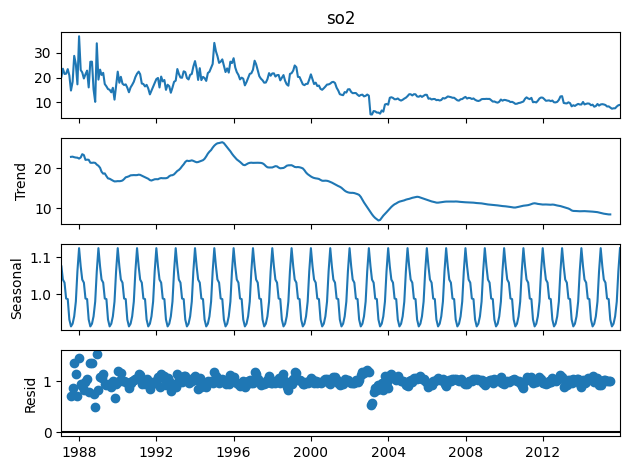

In [201]:
sm.tsa.seasonal_decompose(data_so2["so2"],period = 12, model = 'multiplicative').plot()
plt.show()

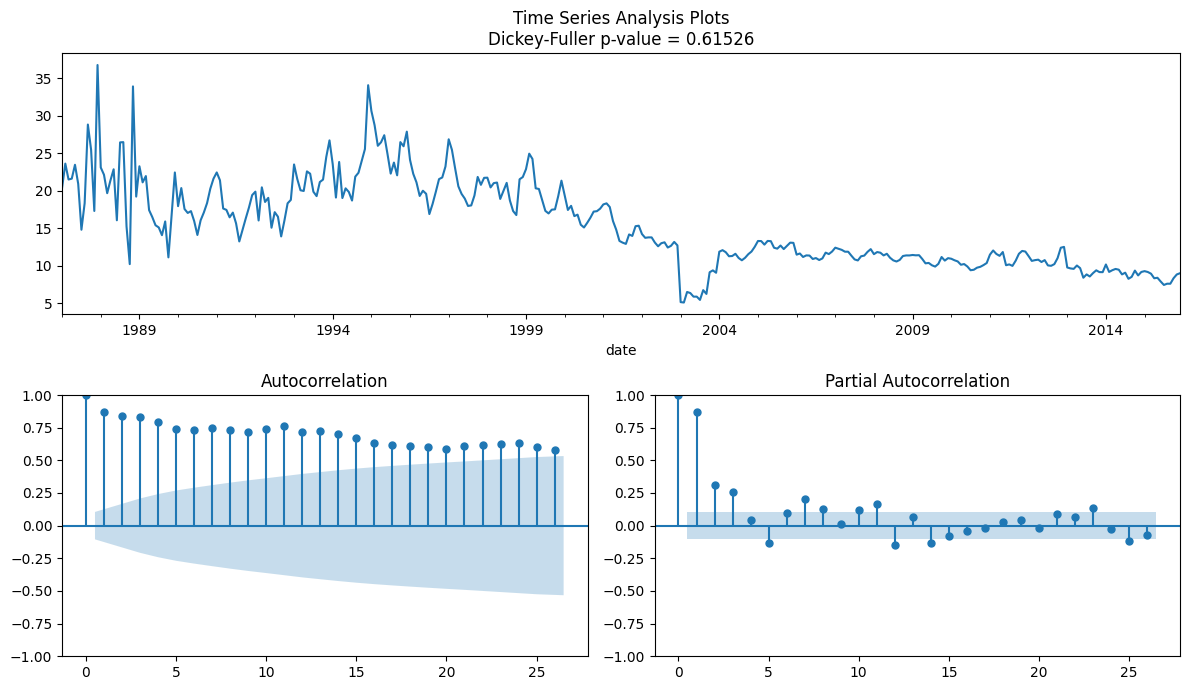

In [202]:
tsplot(data_so2["so2"])

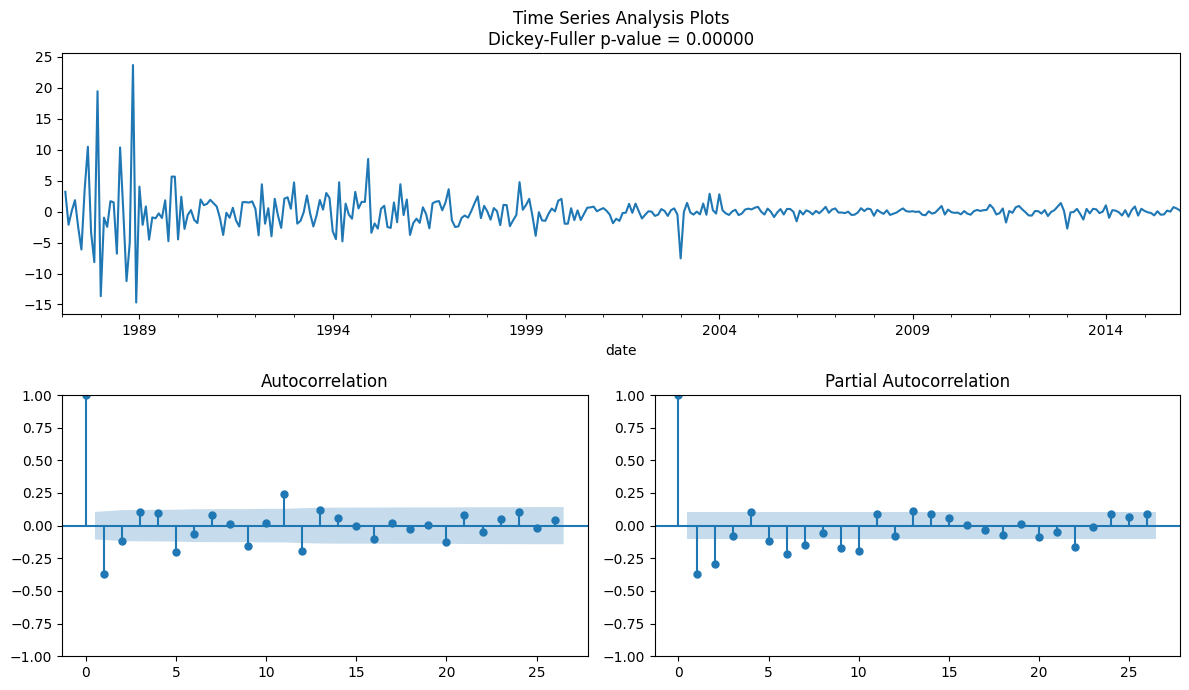

In [203]:
tsplot(data_so2["so2"].diff())

In [204]:
train = data_so2["so2"][:-30]
test = data_so2["so2"][-30:]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

C:\Users\18215\AppData\Local\Temp\ipykernel_23584\976661382.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


predicted = 9.355013, expected = 8.829081
predicted = 9.379621, expected = 8.552750
predicted = 9.138793, expected = 9.001457
predicted = 9.240897, expected = 9.374168
predicted = 9.374150, expected = 9.136925
predicted = 9.259633, expected = 9.128811
predicted = 9.231809, expected = 10.150845
predicted = 9.704379, expected = 9.159081
predicted = 9.313384, expected = 9.391829
predicted = 9.395435, expected = 9.557004
predicted = 9.474186, expected = 9.456250
predicted = 9.441773, expected = 8.830638
predicted = 9.143775, expected = 9.059769
predicted = 9.193301, expected = 8.242843
predicted = 8.774503, expected = 8.504263
predicted = 8.797057, expected = 9.338051
predicted = 9.141530, expected = 8.693150
predicted = 8.869353, expected = 9.155388
predicted = 9.057470, expected = 9.263971
predicted = 9.128689, expected = 9.151181
predicted = 9.100674, expected = 8.925362
predicted = 9.001897, expected = 8.316158
predicted = 8.694189, expected = 8.381349
predicted = 8.652250, expected = 

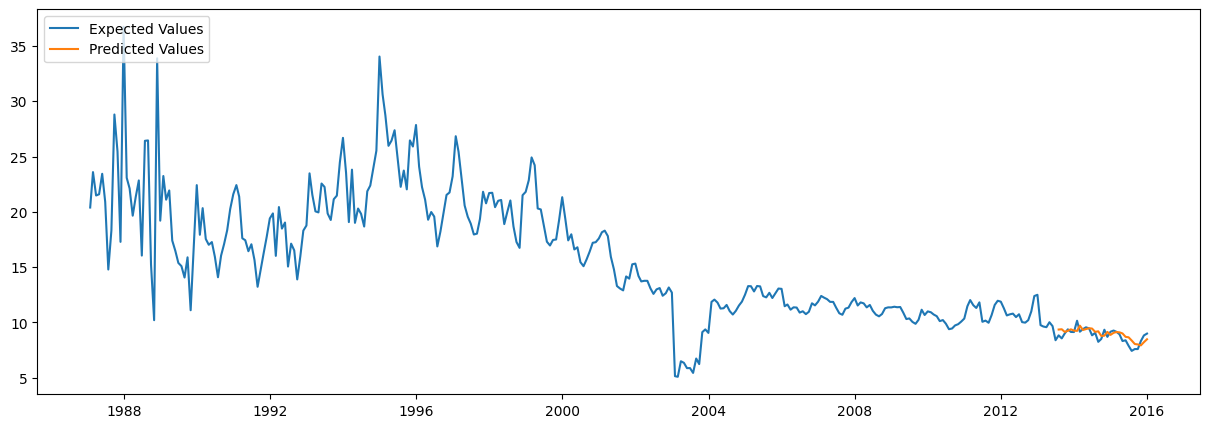

In [205]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data_so2['so2'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [206]:
future = [data_so2.index[-1] + DateOffset(months = x) for x in range(0, 49)]
df = pd.DataFrame(index = future[1:], columns = data_so2.columns)
forecast = pd.concat([data_so2, df])
forecast['ARIMA_Forecast'] = np.nan
forecast

C:\Users\18215\AppData\Local\Temp\ipykernel_23584\3675486145.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecast = pd.concat([data_so2, df])


,so2,ARIMA_Forecast
1987-01-31,20.388571,NaN
1987-02-28,23.591176,NaN
1987-03-31,21.476596,NaN
1987-04-30,21.588235,NaN
1987-05-31,23.438462,NaN
...,...,...
2019-08-31,NaN,NaN
2019-09-30,NaN,NaN
2019-10-31,NaN,NaN
2019-11-30,NaN,NaN


In [207]:
history = [x for x in data_so2["so2"]]
f = []

for t in range(len(forecast) - len(data_so2)):
    
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    
    output = model_fit.forecast()[0]
    history.append(output)
    f.append(output) 

for i in range(len(f)):
    forecast.iloc[348 + i, 1] = f[i]

<Axes: >

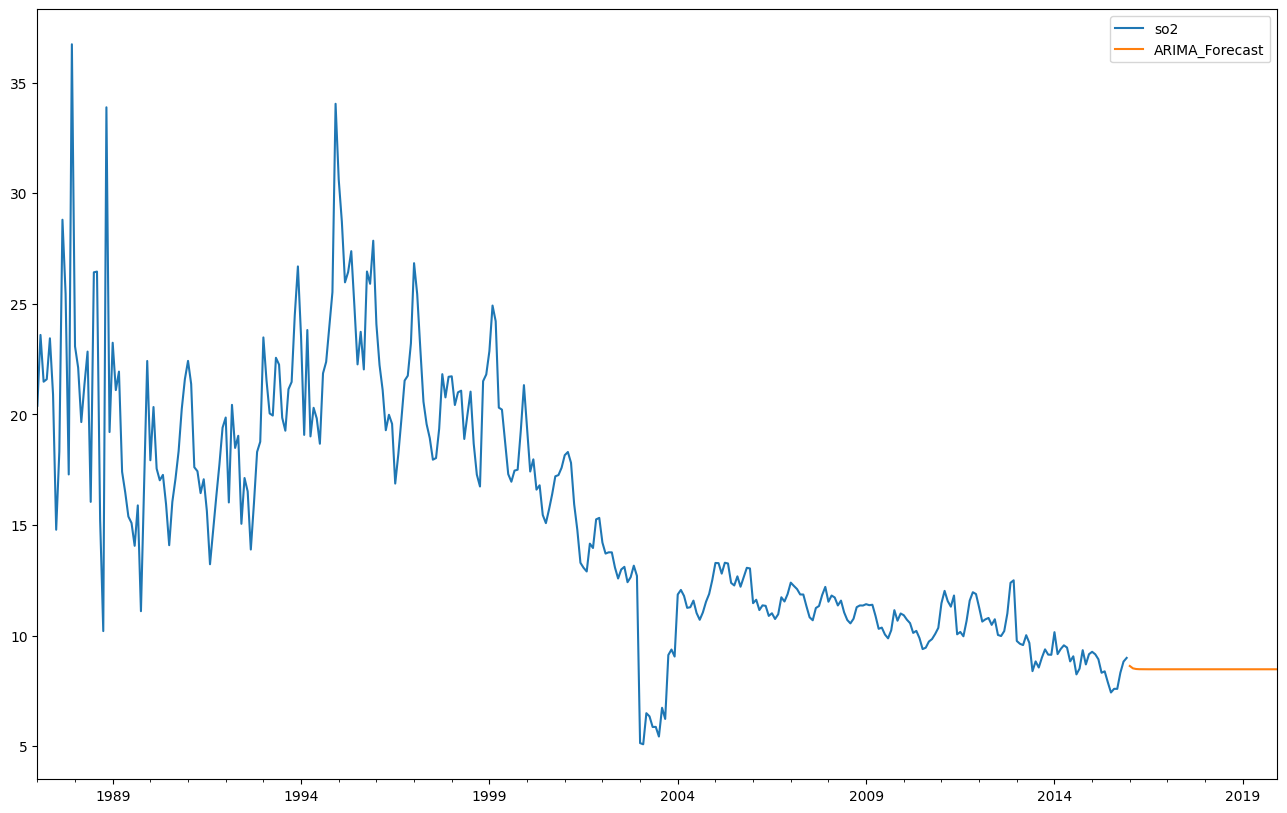

In [208]:
forecast[["so2", "ARIMA_Forecast"]].plot(figsize = (16, 10))

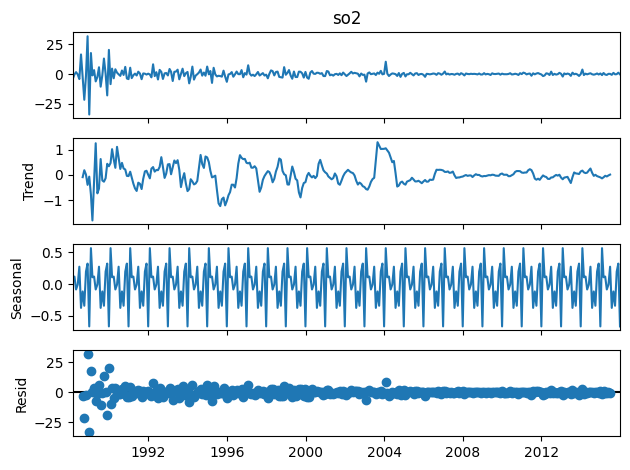

In [217]:
sm.tsa.seasonal_decompose(data_so2["so2"].diff().diff(12).dropna(), period = 12).plot()
plt.show()

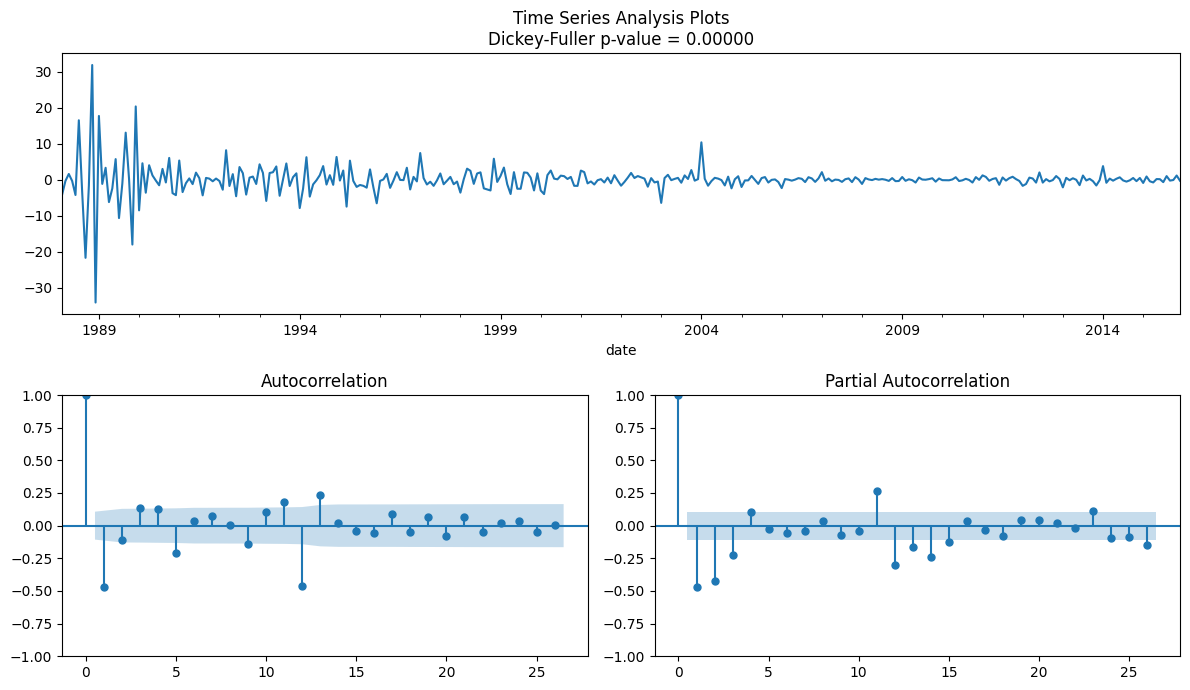

In [219]:
tsplot(data_so2["so2"].diff().diff(12).dropna())

In [220]:
model = sm.tsa.statespace.SARIMAX(data_so2["so2"], order = (1, 1, 1), seasonal_order = (0, 1, 0, 12))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 so2   No. Observations:                  348
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -880.766
Date:                             Mon, 28 Apr 2025   AIC                           1767.532
Time:                                     15:07:50   BIC                           1778.974
Sample:                                 01-31-1987   HQIC                          1772.093
                                      - 12-31-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1124      0.030     -3.759      0.000      -0.171      -0.054
ma.L1         -0.6315      

In [222]:
train = data_so2["so2"][:-30]
test = data_so2["so2"][-30:]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = sm.tsa.statespace.SARIMAX(history, order = (1, 1, 1), seasonal_order = (0, 1, 0, 12))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

C:\Users\18215\AppData\Local\Temp\ipykernel_23584\3892343291.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


predicted = 8.818825, expected = 8.829081
predicted = 8.642732, expected = 8.552750
predicted = 8.859186, expected = 9.001457
predicted = 9.686644, expected = 9.374168
predicted = 11.002694, expected = 9.136925
predicted = 10.611978, expected = 9.128811
predicted = 7.333532, expected = 10.150845
predicted = 7.818469, expected = 9.159081
predicted = 8.351858, expected = 9.391829
predicted = 9.148161, expected = 9.557004
predicted = 8.981441, expected = 9.456250
predicted = 7.851730, expected = 8.830638
predicted = 8.580073, expected = 9.059769
predicted = 8.504561, expected = 8.242843
predicted = 8.917464, expected = 8.504263
predicted = 9.158855, expected = 9.338051
predicted = 8.935872, expected = 8.693150
predicted = 8.884110, expected = 9.155388
predicted = 9.953261, expected = 9.263971
predicted = 8.810193, expected = 9.151181
predicted = 9.069744, expected = 8.925362
predicted = 9.233306, expected = 8.316158
predicted = 8.881708, expected = 8.381349
predicted = 8.053011, expected 

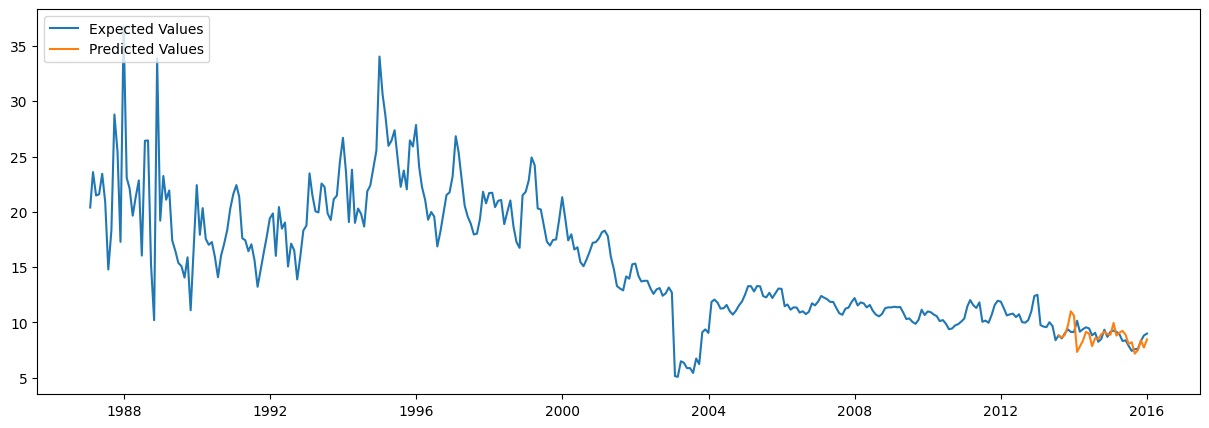

In [223]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data_so2['so2'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [224]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 0.8681


In [225]:
future = [data_so2.index[-1] + DateOffset(months = x) for x in range(0, 49)]
df = pd.DataFrame(index = future[1:], columns = data_so2.columns)
forecast = pd.concat([data_so2, df])
forecast['SARIMA_Forecast'] = np.nan
forecast

C:\Users\18215\AppData\Local\Temp\ipykernel_23584\1067152827.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecast = pd.concat([data_so2, df])


,so2,SARIMA_Forecast
1987-01-31,20.388571,NaN
1987-02-28,23.591176,NaN
1987-03-31,21.476596,NaN
1987-04-30,21.588235,NaN
1987-05-31,23.438462,NaN
...,...,...
2019-08-31,NaN,NaN
2019-09-30,NaN,NaN
2019-10-31,NaN,NaN
2019-11-30,NaN,NaN


In [231]:
history = [x for x in data_so2["so2"]]
f = []

for t in range(len(forecast) - len(data_so2)):
    
    model = sm.tsa.statespace.SARIMAX(history, order = (1, 1, 1), seasonal_order = (0, 1, 0, 12))
    model_fit = model.fit()
    
    output = model_fit.forecast()[0]
    history.append(output)
    f.append(output) 

for i in range(len(f)):
    forecast.iloc[348 + i, 1] = f[i]

<Axes: >

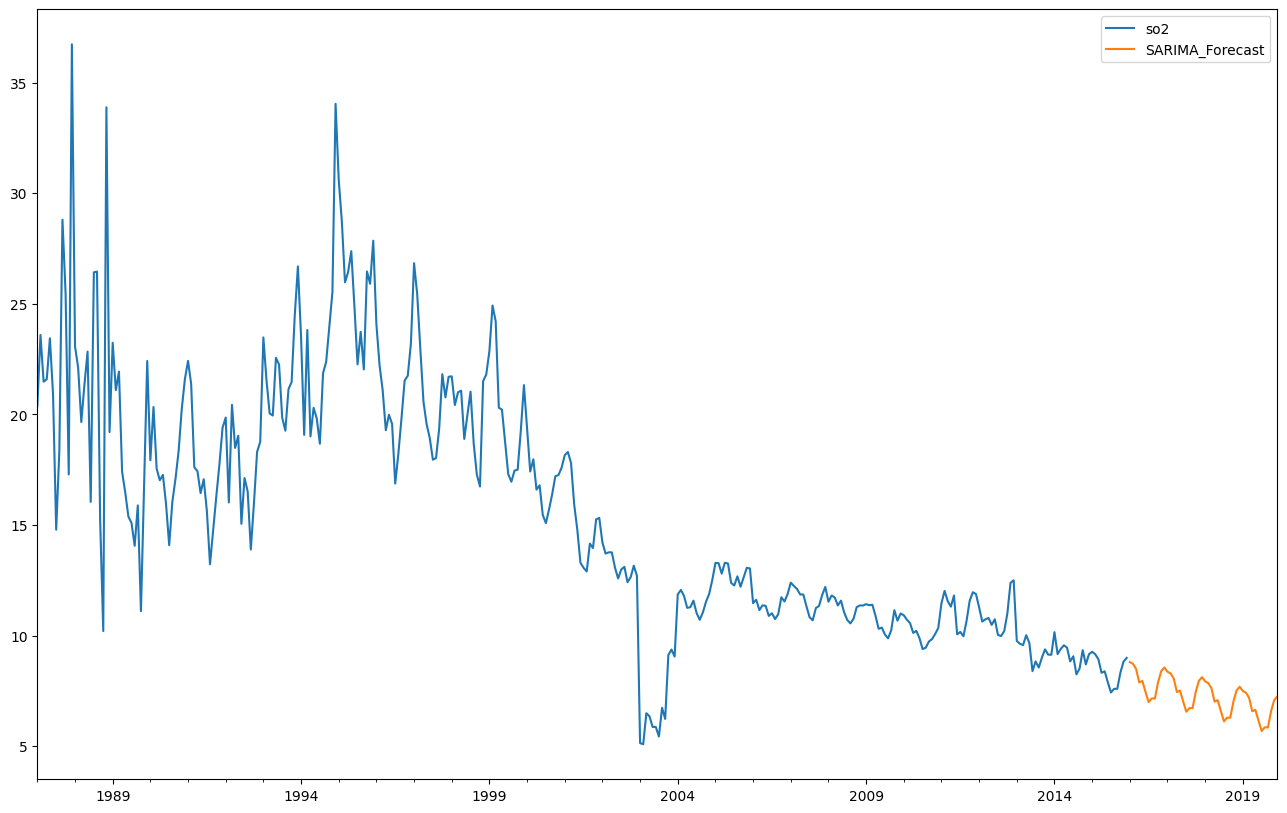

In [232]:
forecast[["so2", "SARIMA_Forecast"]].plot(figsize = (16, 10))